# Integral Equation Model Comparisons
Purpose of this notebook is to EOS calculations for comparisons to George Petrov's Average Atom model, and Morales EOS Hydrogen paper

[https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n, P_Ideal_Fermi_Gas, E_Ideal_Fermi_Gas 


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")

ModuleNotFoundError: No module named 'mendeleev'


#### Load Morales Data

In [3]:
Morales_file = "Morales_EOS_data.dat"
Morales_df = read_csv(Morales_file, delim_whitespace=True, header=4)
Morales_EAU  = Morales_df['E[AU]']
Morales_PGPa = Morales_df['P[GPa]']
Morales_TK   = Morales_df['T[K]']
Morales_PMbar =  1e-2*Morales_PGPa
Morales_TeV = Morales_TK/eV_to_K

### Set Parameters in Paper and Plot

In [4]:
name = 'Hydrogen'
Z, A = 1,1 

Te_eV_list = np.geomspace(np.array(Morales_TeV)[0], 1000, num=5) #np.array(GP_Te_eV) # eV
Ti_eV_list = Te_eV_list
ni_cc = 5.98e23
ni_AU = ni_cc/cm_to_AU**3

ri_cm = rs_from_n(ni_cc)  # cm
ri_AU = ri_cm*cm_to_AU    # AU 

#### Run Ornstein-Zernike Closure

In [5]:
# Define plasma method to use
name = 'OZ - th  Pauli'
plasma_func = lambda T_eV, ni_cc: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':1000,'N_bins':50000, 
                               'h_max':1e3,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})

# Helpful unit functions
P_hnc_to_AU   = lambda P_hnc, ri: (P_hnc/ri**3) 
P_hnc_to_bar  = lambda P_hnc, ri: P_hnc_to_AU(P_hnc, ri) *  AU_to_bar 
P_hnc_to_Mbar = lambda P_hnc, ri: 1e-6*P_hnc_to_bar(P_hnc, ri)
P_hnc_to_GPa  = lambda P_hnc, ri: P_hnc_to_bar(P_hnc, ri) * 1e5 / 1e9 
E_hnc_to_eV   = lambda E_hnc: E_hnc/(3/(4*π)) * AU_to_eV

P_hnc_to_AU = np.vectorize(P_hnc_to_AU)
P_hnc_to_bar = np.vectorize(P_hnc_to_bar)
P_hnc_to_Mbar = np.vectorize(P_hnc_to_Mbar)
P_hnc_to_GPa = np.vectorize(P_hnc_to_GPa)
E_hnc_to_eV = np.vectorize(E_hnc_to_eV)

# Create new thermodynamic variable generator
def excess_energy_density_matrix(plasma, d_βu ): # Defining   d_βu = dβ_c u/dβ = -T^2 d β_c u/dT
    g_matrix = plasma.hnc.h_r_matrix+1
    rho_matrix = plasma.hnc.rho[:,np.newaxis] * plasma.hnc.rho[np.newaxis,:]
    r = plasma.hnc.r_array[np.newaxis,np.newaxis,:]
    dr = plasma.hnc.del_r
    
    u_ex_matrix = np.sum(2*π*rho_matrix[:,:,np.newaxis]*d_βu*g_matrix*r**2*dr,axis=2)
    return u_ex_matrix

def ideal_energy_density_matrix(plasma, d_β):
    u_i_id   = 3/2 * plasma.hnc.rho[0] * plasma.qsp.Ti
    u_e_c_id = 3/2 * plasma.hnc.rho[1] * plasma.qsp.Te_c
    u_e_id   = u_e_c_id * ( d_β )#  + 0*mass) # IGNORING MASS RUNNING FOR NOW
    return np.diag([u_i_id, u_e_id ])

def chemical_potential_addition():
    return None


def get_U_matrices(plasma_pair):
#     print( "NOT FINISHED" )
#     plasma, plasma_ε = plasma_pair
#     plasma_ε.run_hnc(c_s_k_guess = plasma.hnc.c_s_k_matrix.copy())
#     dT_AU = plasma.Ti - plasma_ε.Ti
#     T_AU = plasma.Ti
    
#     # Now we need   d_βu = dβ_c u/dβ = -T^2 d β_c u/dT
#     dβu_dβ_AU = (plasma.hnc.βu_r_matrix - plasma_ε.hnc.βu_r_matrix)/(plasma.qsp.βe - plasma_ε.qsp.βe )
#     dβc_dβ    = ( 1/plasma.hnc.Temp_matrix - 1/plasma_ε.hnc.Temp_matrix)/(plasma.qsp.βe - plasma_ε.qsp.βe )

#     # Get energies
#     U_ex = excess_energy_density_matrix(plasma, d_βu_AU )
#     U_id = ideal_energy_density_matrix(plasma, dβc_dβ)
#     U_standard = plasma.hnc.energy_density_matrix()
    
#     # Convert units
#     E_id_AU, E_ex_AU, E_st_AU, E_AU = U_id/plasma.hnc.rho[0], U_ex/plasma.hnc.rho[0], U_standard/plasma.hnc.rho[0], (U_id + U_ex)/plasma.hnc.rho[0]
#     E_id_eV, E_ex_eV, E_st_eV, E_eV = np.array([E_id_AU, E_ex_AU, E_st_AU, E_AU])*AU_to_eV
    return 0,0,0,0 #E_id_eV, E_ex_eV, E_st_eV, E_eV


def get_P_matrices(plasma_pair):
    plasma, plasma_ε = plasma_pair
    plasma_ε.run_hnc(c_s_k_guess = plasma.hnc.c_s_k_matrix.copy())
    dn_AU = plasma.ni_AU - plasma_ε.ni_AU
    n_AU = plasma.ni_AU
    r_AU = rs_from_n(n_AU)

    # Get pressures
    P_ex_standard = plasma.hnc.excess_pressure_matrix()
    P_id_standard = np.diag(plasma.hnc.rho*plasma.hnc.Temp_list)

    dlnβcdlnn = (np.log(plasma_ε.hnc.Temp_matrix/plasma.hnc.Temp_matrix))/(np.log(plasma.ni_AU/plasma_ε.ni_AU))
    P_ex_new = P_ex_standard * plasma.Ti/plasma.hnc.Temp_matrix
    P_id_new = P_id_standard * ( 1 + 3/2*dlnβcdlnn )

    print("Pressures: ", P_ex_new, P_ex_standard)

    # New excess energy derivative term in pressure
    dβu_dlnn_AU = n_AU*(plasma.hnc.βu_r_matrix - plasma_ε.hnc.βu_r_matrix)/dn_AU
    P_nonstandard = excess_energy_density_matrix(plasma, plasma.Ti * dβu_dlnn_AU  )
    
    # Combine results
    P_standard = P_ex_standard + P_id_standard
    P_id_Mbar, P_ex_Mbar, P_standard_Mbar, P_Mbar = P_hnc_to_Mbar(P_id_new,r_AU), P_hnc_to_Mbar(P_ex_new,r_AU), P_hnc_to_Mbar(P_standard,r_AU), P_hnc_to_Mbar(P_id_new + P_ex_new + P_nonstandard,r_AU)
    return P_id_Mbar, P_ex_Mbar, P_standard_Mbar, P_Mbar


def get_U(plasma, ε=1e-6):
    plasma_pair = [plasma, plasma_func(plasma.Ti_eV*(1-ε), plasma.ni_cc)]
    U_id_matrix, U_ex_matrix, U_st_matrix, U_matrix = get_U_matrices(plasma_pair)
    return np.sum(U_id_matrix), np.sum(U_ex_matrix), np.sum(U_st_matrix), np.sum(U_matrix)

def get_P(plasma, ε=1e-6):
    plasma_pair = [plasma, plasma_func(plasma.Ti_eV, plasma.ni_cc*(1-ε))]
    P_id_matrix, P_ex_matrix, P_st_matrix, P_matrix = get_P_matrices(plasma_pair)
    return np.sum(P_id_matrix), np.sum(P_ex_matrix), np.sum(P_st_matrix), np.sum(P_matrix)


# get_U_matrices(plasma_pair_func(1e4))

### Compute all plasma models for list of densities

In [6]:
EOS_list = []

for T_eV in Te_eV_list:
    plasma = plasma_func(T_eV, ni_cc)
    plasma.run_hnc()
    
    E_id_eV, E_ex_eV, E_st_eV, E_eV         = get_U(plasma)
    P_id_Mbar, P_ex_Mbar, P_st_Mbar, P_Mbar = get_P(plasma)
    EOS_list.append( [[E_id_eV, E_ex_eV, E_st_eV, E_eV],[P_id_Mbar, P_ex_Mbar, P_st_Mbar, P_Mbar]] )
    
EOS_list = np.array(EOS_list)

Te_in_eV: 0.172
Ti_in_eV: 0.172


/home/zach/plasma/hnc/hnc/PIE.py:158: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


0: Initial condition Total Error: 1.714e+01


/home/zach/plasma/hnc/hnc/hnc.py:663: RuntimeWarning: overflow encountered in exp
  hnc_err = np.linalg.norm(- 1 - self.h_r_matrix   + np.exp( -self.βu_r_matrix + self.h_r_matrix - self.c_r_matrix ))/np.sqrt(self.N_bins*self.N_species**2)
/home/zach/plasma/hnc/hnc/hnc.py:447: RuntimeWarning: overflow encountered in exp
  tot_eqn =  1 + h_r_matrix  - np.exp(-self.βu_s_r_matrix + h_r_matrix - c_s_r_matrix )
/home/zach/plasma/hnc/hnc/hnc.py:533: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)
/home/zach/plasma/hnc/hnc/hnc.py:671: RuntimeWarning: invalid value encountered in subtract
  Δ_err = np.array(self.tot_err_list[-iters_to_check:-2]) - np.array(self.tot_err_list[-iters_to_check + 1:-1])


QUIT: Total error infinite.
Exiting status 1, reverting to best index so far: 0
Final iter:21, Total Error: 1.714e+01
QUIT: Picard Err too high. Newton assumed not to converge. Try better initial condition or smaller α.
Te_in_eV: 0.172
Ti_in_eV: 0.172
Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 1.714e+01
QUIT: Total error infinite.
Exiting status 1, reverting to best index so far: 0
Final iter:21, Total Error: 1.714e+01
QUIT: Picard Err too high. Newton assumed not to converge. Try better initial condition or smaller α.
Pressures:  [[ 42893.46532703 -42891.71730836]
 [-42891.71730836  42890.04400948]] [[ 42893.46532703 -42891.71730836]
 [-42891.71730836  42890.04400948]]
Te_in_eV: 1.504
Ti_in_eV: 1.504
0: Initial condition Total Error: 3.238e-01
Exiting status 0, reverting to best index so far: 119
Final iter:120, Total Error: 8.921e-09
Te_in_eV: 1.504
Ti_in_eV: 1.504
Te_in_eV: 1.504
Ti_in_eV: 1.504
0: Initial condition Total Error: 1.528e-07
Exiting status 0, rev

### Energy per Atom

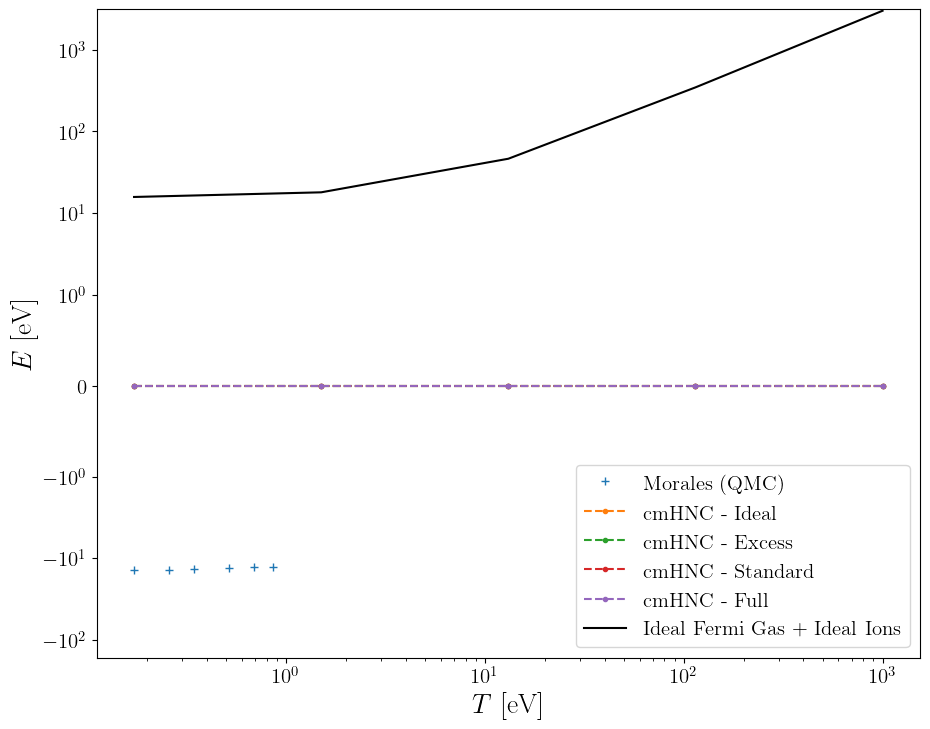

In [29]:
from hnc.hnc.misc import Fermi_Energy

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_EAU*AU_to_eV, '+', label='Morales (QMC)')

# Plot Energy
axs[0].plot(Te_eV_list, EOS_list[:,0,0],'--.', label="cmHNC - Ideal")
axs[0].plot(Te_eV_list, EOS_list[:,0,1],'--.', label="cmHNC - Excess")
axs[0].plot(Te_eV_list, EOS_list[:,0,2],'--.', label="cmHNC - Standard")
axs[0].plot(Te_eV_list, EOS_list[:,0,3],'--.', label="cmHNC - Full")

# Plot Fermi Gas Energy
E_ideal_eV_func = lambda Te_eV, Ti_eV: E_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_eV + 3/2*Ti_eV
E_ideal_eV_func = np.vectorize(E_ideal_eV_func)

Ee_ideal_eV = [E_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_eV for Te_eV in Te_eV_list]
Ei_ideal_eV = 3/2*Ti_eV_list

# axs[0].plot(Te_eV_list, Ee_ideal_eV,'k--', label="Ideal Fermi Gas"  ) 
# axs[0].plot(Te_eV_list, 3/5*Fermi_Energy(ni_AU)*np.ones_like(Te_eV_list)*AU_to_eV,'k--.', label="Degnerate Fermi Gas"  ) 
# axs[0].plot(Te_eV_list, Ei_ideal_eV,'k-.', label="Ideal Gas"  ) 
axs[0].plot(Te_eV_list, Ee_ideal_eV + Ei_ideal_eV,'k-', label="Ideal Fermi Gas + Ideal Ions"  ) 

for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$E$ [eV]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()

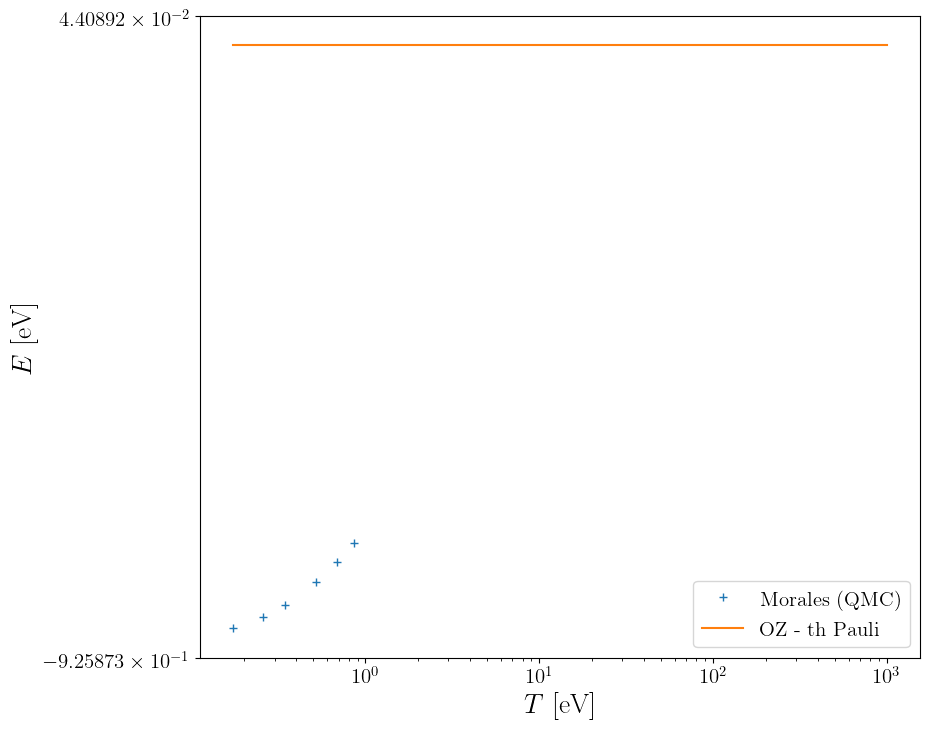

In [30]:
from hnc.hnc.misc import Fermi_Energy

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_EAU*AU_to_eV/E_ideal_eV_func(Morales_TeV,Morales_TeV), '+', label='Morales (QMC)')

# Plot Energy
axs[0].plot(Te_eV_list, EOS_list[:,0,2]/E_ideal_eV_func(Te_eV_list,Te_eV_list), label=name)

for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$E$ [eV]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()

### Plot Pressures

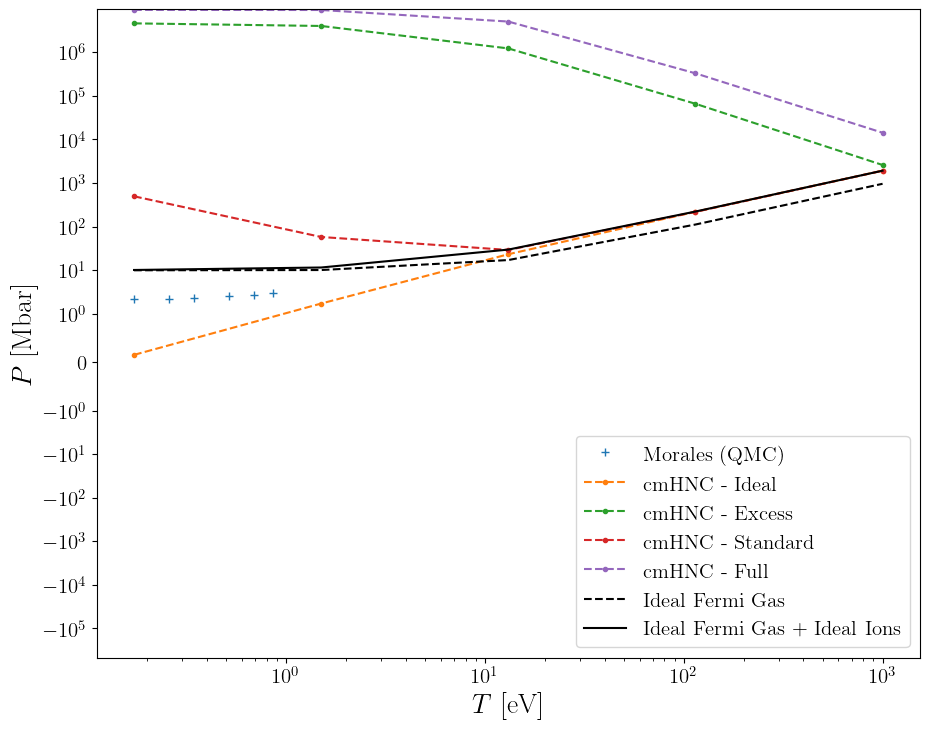

In [31]:

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_PMbar, '+', label='Morales (QMC)')

# Plot Pressure 
axs[0].plot(Te_eV_list, EOS_list[:,1,0],'--.', label="cmHNC - Ideal")
axs[0].plot(Te_eV_list, EOS_list[:,1,1],'--.', label="cmHNC - Excess")
axs[0].plot(Te_eV_list, EOS_list[:,1,2],'--.', label="cmHNC - Standard")
axs[0].plot(Te_eV_list, EOS_list[:,1,3],'--.', label="cmHNC - Full")

# Plot Fermi Pressure
Pe_ideal_Mbar = [P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_bar/1e6 for Te_eV in Te_eV_list]
Pi_ideal_Mbar = Ti_eV_list*eV_to_AU*ni_AU*AU_to_bar/1e6

axs[0].plot(Te_eV_list, Pe_ideal_Mbar,'k--', label="Ideal Fermi Gas"  ) 
axs[0].plot(Te_eV_list, Pe_ideal_Mbar + Pi_ideal_Mbar,'k-', label="Ideal Fermi Gas + Ideal Ions"  ) 

for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$P$ [Mbar]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()

#### Plot Pressure over Ideal Pressure

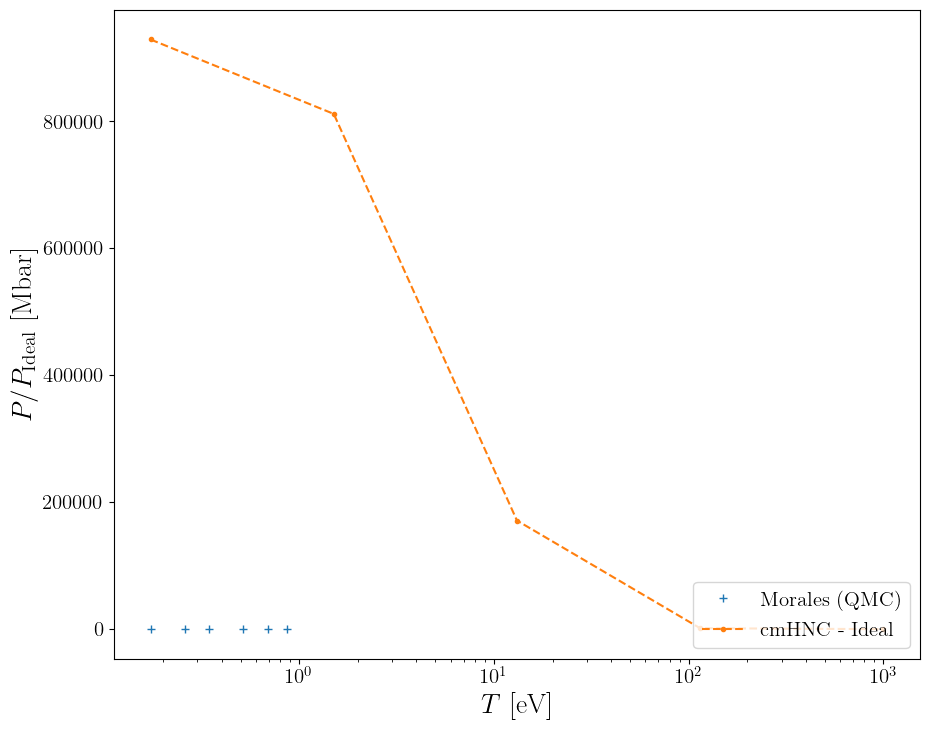

In [32]:
fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

# Plot Fermi Pressure
P_ideal_Mbar_func = lambda Te_eV, Ti_eV: P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_bar/1e6 + Ti_eV*eV_to_AU*ni_AU*AU_to_bar/1e6
P_ideal_Mbar_func = np.vectorize(P_ideal_Mbar_func)

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_PMbar/[P_ideal_Mbar_func(T_eV, T_eV) for T_eV in Morales_TeV], '+', label='Morales (QMC)')

# Plot Pressure ratio
axs[0].plot(Te_eV_list, EOS_list[:,1,3]/P_ideal_Mbar_func(Te_eV_list,Te_eV_list),'--.', label="cmHNC - Ideal")
# axs[0].plot(Te_eV_list, EOS_list[:,1,1],'--.', label="cmHNC - Excess")
# axs[0].plot(Te_eV_list, EOS_list[:,1,2],'--.', label="cmHNC - Standard")
# axs[0].plot(Te_eV_list, EOS_list[:,1,3],'--.', label="cmHNC - Full")


for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    # ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$P/P_{\rm Ideal}$ [Mbar]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()